# 2024 Fall MLDL midterm
R12521521 吳竣名

In [18]:
# import those package we need 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # 引入 tqdm
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## 1. Import data

In [19]:
def read_csv_file(file_name, index_col = 0):
    current_dir = os.getcwd()
    file_path = os.path.join(current_dir, file_name)
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    return pd.read_csv(file_path, index_col = index_col)

try:
    df_raw_train = read_csv_file('train.csv')
    df_raw_test = read_csv_file('X_test.csv')

    print("raw train data:", df_raw_train.shape)
    print("test data:", df_raw_test.shape)

    # X_train = df_raw_train.drop('label', axis=1)
    # y_train = df_raw_train['label'].values.reshape(-1, 1)

    # print("X_train shape:", X_train.shape)
    # print("y_train shape:", y_train.shape)

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unknown error occurred: {e}")

raw train data: (11000, 26)
test data: (2100, 25)


## 2. EDA

### 2.1 Observed data

### 2.2 features engineering

In [20]:
# Drop columns(features)
df_raw_train = df_raw_train.drop(['bnsfg','iterm','flbmk','insfg','flam1'], 
                                 axis = 1, 
                                 inplace = False
                                 )

df_raw_test = df_raw_test.drop(['bnsfg','iterm','flbmk','insfg','flam1'],
                                axis = 1,
                                inplace = False 
                                )

#### Add new features

In [21]:
# 計算當次消費跟所有過去平均消費之間的差異

df_raw_train['avg_conam'] = df_raw_train.groupby('cano')['conam'].transform('mean')
df_raw_train['diff_conam'] = df_raw_train['conam'] - df_raw_train['avg_conam']

In [22]:
# 計算當次刷卡城市是否是第一次出現

df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'scity'])['locdt'].transform('min')
df_raw_train['is_city_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

In [23]:
# 計算當次消費幣別是否是第一次出現

df_raw_train['first_appearance'] = df_raw_train.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_raw_train['is_csmcu_first_appearance'] = df_raw_train['locdt'] == df_raw_train['first_appearance']

In [24]:
# 計算總刷卡次數 / 是否該次交易為第一次使用該張卡片 / 每日的刷卡次數 
df_raw_train['cano_count'] = df_raw_train.groupby('cano')['cano'].transform('count')
df_raw_train['Is_First_Occurrence'] = ~df_raw_train['cano'].duplicated()
df_raw_train['freq_perday'] = df_raw_train.groupby(['cano','locdt'])['cano'].transform('count')

In [25]:
# Set category
df_raw_train['category'] = 'category1'
df_raw_test['category'] = 'category2'

# Concatenate training and test datasets
df_concat = pd.concat([df_raw_train, df_raw_test],
                       ignore_index = True, 
                       axis = 0
                       )

df_concat['avg_conam'] = df_concat.groupby('cano')['conam'].transform('mean')
df_concat['diff_conam'] = df_concat['conam'] - df_concat['avg_conam']
df_concat['first_appearance'] = df_concat.groupby(['cano', 'scity'])['locdt'].transform('min')
df_concat['is_city_first_appearance'] = df_concat['locdt'] == df_concat['first_appearance']
df_concat['first_appearance'] = df_concat.groupby(['cano', 'csmcu'])['locdt'].transform('min')
df_concat['is_csmcu_first_appearance'] = df_concat['locdt'] == df_concat['first_appearance']
df_concat['cano_count'] = df_concat.groupby('cano')['cano'].transform('count')
df_concat['Is_First_Occurrence'] = ~df_concat['cano'].duplicated()

In [26]:
df_raw_train = df_raw_train.drop(['category','avg_conam','first_appearance'], 
                                 axis = 1, inplace = False
                                 )

df_raw_test = df_concat[df_concat['category']=='category2'].reset_index(drop = True)

df_raw_test = df_raw_test.drop(['category','avg_conam','first_appearance','label'], 
                               axis = 1, inplace = False
                               )

df_raw_test['freq_perday'] = df_raw_test.groupby(['cano','locdt'])['cano'].transform('count')

del df_concat

df_raw_test.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,hcefg,csmcu,csmam,flg_3dsmk,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
0,f3e8f070d3706fd8283cf407528e7c29d877052ac2c0d7...,56.0,NaN,3233a816a88afeeec361f4c25d51963fdbee018f8524bb...,6022236097bfad74e6e2ede83b792b7bf99f9097158e3e...,5.0,5.0,cc519c93a036e7d461640f8e85affc1112e8dd5774426b...,NaN,406.0,...,6.0,70.0,-329.356052,0.0,0.0,True,True,1.0,True,1.0
1,c863a3a3b49d489274c570a1a468245c914466f4549433...,59.0,50236.0,243110d53e4f1351a7e062fb05a2318592a5ea0583bdea...,NaN,5.0,8.0,69709838f1848ae27b80c6615c516e23b84aebd1eaa7ce...,f2c487098d95cf4d74628e9a2a1cffc7beee347c46e19f...,324.0,...,NaN,29.0,84.482536,0.0,NaN,False,False,NaN,False,NaN
2,5ff4683b5d517fd087f9fe3653d08e6fa8365129f0d9f0...,59.0,4104.0,f8d9f6c50c2d2ff73112ab094f75e53b14118ac77ce7b7...,NaN,5.0,8.0,45b6cb170af96950ffd009b6275bb22f5f5b052687d237...,c6a68a6677409cd8b8e909a2b2766ed5f26668e9862631...,326.0,...,6.0,NaN,1530.061345,0.0,NaN,False,False,NaN,False,NaN
3,b799904c9eb8e3a6249fce84da5f745a751bc4bcefb321...,59.0,101305.0,5525e5ff3373de116e5f7f9912d391fdaf4261fa6b4bea...,NaN,NaN,1.0,4d7ccd00c86844f54a3db3fbc2b9b6d594e33102996485...,NaN,375.0,...,6.0,70.0,54.312320,0.0,NaN,False,False,NaN,False,NaN
4,054f1506347491470cb95d5be52153ad6c12ff1c533dce...,59.0,103356.0,0e6e8a0680405bcca222fee6d6a1c41197754676495d51...,e1176e84da0a0f5ef4f9934c12313127ba0860c17f4e7f...,5.0,NaN,9f42eb2f5d964a1e34a7ea611f111145559463e9759833...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,NaN,...,0.0,NaN,48.464017,0.0,0.0,False,False,1.0,True,1.0


#### Observed new data

In [27]:
print(df_raw_train.columns)
print(df_raw_train.shape)

print(df_raw_test.columns)
print(df_raw_test.shape)

Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'label', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')
(11000, 27)
Index(['txkey', 'locdt', 'loctm', 'chid', 'cano', 'contp', 'etymd', 'mchno',
       'acqic', 'mcc', 'conam', 'ecfg', 'stocn', 'scity', 'stscd', 'ovrlt',
       'hcefg', 'csmcu', 'csmam', 'flg_3dsmk', 'diff_conam',
       'is_city_first_appearance', 'is_csmcu_first_appearance', 'cano_count',
       'Is_First_Occurrence', 'freq_perday'],
      dtype='object')
(2100, 26)


#### Fil missing values (with data wrangler)

In [28]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df_raw_train):
    # Replace missing values with 99 in column: 'etymd'
    df_raw_train = df_raw_train.fillna({'etymd': 99})
    # Replace missing values with 99 in column: 'stscd'
    df_raw_train = df_raw_train.fillna({'stscd': 99})
    # Replace missing values with 999 in column: 'stocn'
    df_raw_train = df_raw_train.fillna({'stocn': 999})
    # Replace missing values with 999 in column: 'hcefg'
    df_raw_train = df_raw_train.fillna({'hcefg': 999})
    # Replace missing values with 999 in column: 'csmcu'
    df_raw_train = df_raw_train.fillna({'csmcu': 999})
    # Replace missing values with 999 in column: 'scity'
    df_raw_train = df_raw_train.fillna({'scity': 999})
    # Replace missing values with 999 in column: 'mcc'
    df_raw_train = df_raw_train.fillna({'mcc': 999})

    # Drop rows with missing data in column: 'txkey'
    df_raw_train = df_raw_train.dropna(subset=['txkey'])
    # Drop rows with missing data in column: 'cano_count'
    df_raw_train = df_raw_train.dropna(subset=['cano_count'])

    # Replace gaps forward from the previous valid value in: 'locdt'
    df_raw_train = df_raw_train.fillna({'locdt': df_raw_train['locdt'].ffill()})
    # Replace gaps forward from the previous valid value in: 'loctm'
    df_raw_train = df_raw_train.fillna({'loctm': df_raw_train['loctm'].ffill()})
    # Replace gaps forward from the previous valid value in: 'contp'
    df_raw_train = df_raw_train.fillna({'contp': df_raw_train['contp'].ffill()})
    # Replace gaps back from the next valid value in: 'conam'
    df_raw_train = df_raw_train.fillna({'conam': df_raw_train['conam'].bfill()})
    # Replace gaps forward from the previous valid value in: 'ecfg'
    df_raw_train = df_raw_train.fillna({'ecfg': df_raw_train['ecfg'].ffill()})
    # Replace missing values with the median of each column in: 'ovrlt'
    df_raw_train = df_raw_train.fillna({'ovrlt': df_raw_train['ovrlt'].median()})
    # Replace gaps forward from the previous valid value in: 'csmam'
    df_raw_train = df_raw_train.fillna({'csmam': df_raw_train['csmam'].ffill()})
    # Replace gaps forward from the previous valid value in: 'flg_3dsmk'
    df_raw_train = df_raw_train.fillna({'flg_3dsmk': df_raw_train['flg_3dsmk'].ffill()})
    # Replace missing values with 0 in column: 'diff_conam'
    df_raw_train = df_raw_train.fillna({'diff_conam': 0})
    # Replace gaps forward from the previous valid value in: 'cano_count'
    df_raw_train = df_raw_train.fillna({'cano_count': df_raw_train['cano_count'].ffill()})
    # Replace gaps back from the next valid value in: 'freq_perday'
    df_raw_train = df_raw_train.fillna({'freq_perday': df_raw_train['freq_perday'].bfill()})

    return df_raw_train

df_raw_train = clean_data(df_raw_train.copy())

df_raw_train.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,csmcu,csmam,flg_3dsmk,label,diff_conam,is_city_first_appearance,is_csmcu_first_appearance,cano_count,Is_First_Occurrence,freq_perday
1,68dc55fb053b47c06dd29fd01781a6224622478367b8d1...,11.0,150204.0,f23d2d1b2f1e296c31e0df919a55e0e89d7ebd6388fb9c...,1bcf0ba278157b49745d4567b0ba96be4c870a76879b50...,5.0,4.0,03893a476a17b5cfcc9d0b841b88deadd3d782d9ea2d48...,NaN,288.0,...,70.0,NaN,NaN,0,0.0,True,True,1.0,True,1.0
4,489331e11fe3daae734c28160d5f39638441998723a8b6...,16.0,142340.0,2ad812e6a58c600ebb96192baaced1633517cf37e881ed...,049a1d8d173204f285efe1ef19b2bbcb090b2b777e29e1...,5.0,5.0,f04f4d0556d851333cb69e2995ad673f11a7f3acd787e1...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,275.0,...,70.0,1793.200087,0.0,0,0.0,True,True,1.0,True,1.0
5,a47a27fec422e30597c70897b32fbfad4d5c5a123f6b69...,37.0,162123.0,NaN,d15f914f7e1f4d23e0bea7c8dcb8ca73054a9232d868db...,5.0,99.0,4634d294725125a33fa751921fc22c4b692b2e4884cd01...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,70.0,104.487176,0.0,0,0.0,True,True,1.0,True,1.0
6,f35fad9fcd72fd67ca511664557f23727ff6191ba8708d...,4.0,120421.0,ca30de426487915cb31fb090feae60ef2666adef4d8a8c...,2d163a6e809f8dab5e0575840beecbe666d5d7c878375c...,5.0,1.0,489e5caa6e2b65e6cbf57159c18b10b5cfb0d8e28bb3e3...,bfbb5ca8870e18f9ce4ebf53a3908f71261c8221b85734...,378.0,...,70.0,155.034644,0.0,0,0.0,True,True,1.0,True,1.0
7,881fbbe6b626d2fedb391442a27f5828bfd97d82a1e681...,4.0,131038.0,67f79c6c4f94b45b7a9ab49671a2ef2bbf576ffe1f9650...,2dbc484fc7fbacbdd1ec6c99853b731b2fd4520836837e...,5.0,4.0,4da75ef2e01774ae92e598a0ad20e56a034613cac83663...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,999.0,...,70.0,37966.989691,0.0,0,0.0,False,False,1.0,True,1.0


In [29]:
# 建立 dictionary 用來幫 test data 填值，因為有可能遇到 test data 中沒有的值導致我們直接用 label 會使得 encoding 後的值跑掉

label_encoder = LabelEncoder()

X = df_raw_train.drop(['txkey','locdt','label','chid'], 
                      axis = 1, 
                      inplace = False
                      )

Y = df_raw_train[['label']]

# for test data
dict_mchno = dict(zip(X['mchno'],label_encoder.fit_transform(X['mchno']))) #use for test data
dict_acqic = dict(zip(X['acqic'],label_encoder.fit_transform(X['acqic']))) #use for test data
dict_cano = dict(zip(X['cano'],label_encoder.fit_transform(X['cano']))) #use for test data

X['mchno'] = label_encoder.fit_transform(X['mchno'])
X['acqic'] = label_encoder.fit_transform(X['acqic'])
X['cano'] = label_encoder.fit_transform(X['cano'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.1, 
                                                    random_state = 20231123
                                                    )



In [30]:
X_train = X_train.astype(dtype = 'category')
X_test = X_test.astype(dtype = 'category')

y_train = y_train.astype(dtype = 'category')
y_test = y_test.astype(dtype = 'category')

In [31]:
X_train['conam'] = X_train['conam'].astype('float')
X_train['csmam'] = X_train['csmam'].astype('float')

X_train['loctm'] = X_train['loctm'].astype('int')
X_train['cano_count'] = X_train['cano_count'].astype('int')
X_train['diff_conam'] = X_train['diff_conam'].astype('float')
X_train['freq_perday'] = X_train['freq_perday'].astype('int')

X_test['conam'] = X_test['conam'].astype('float')
X_test['csmam'] = X_test['csmam'].astype('float')

X_test['loctm'] = X_test['loctm'].astype('int')
X_test['cano_count'] = X_test['cano_count'].astype('int')
X_test['diff_conam'] = X_test['diff_conam'].astype('float')
X_test['freq_perday'] = X_test['freq_perday'].astype('int')

### 3. Model building

In [32]:
y_train = y_train.astype(dtype = 'int')
y_test = y_test.astype(dtype = 'int')

#### 3.1 LightGBM

In [33]:
# LightGBM
# y_train = y_train.astype(dtype = 'int')
# y_test = y_test.astype(dtype = 'int')

lgbm_train = lgb.Dataset(X_train, label = y_train)

lgbm_eval = lgb.Dataset(X_test, label = y_test, reference = lgbm_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 10
}

num_round = 3000
#bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval])

bst = lgb.train(params, lgbm_train, num_round, 
                valid_sets = [lgbm_train, lgbm_eval], 
                callbacks = [lgb.early_stopping(stopping_rounds = 200)]
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 647, number of negative: 6441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [bina

#### 3.2 Random forest #################

In [34]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(X_train):
    # Change column type to float64 for column: 'flg_3dsmk'
    X_train = X_train.astype({'flg_3dsmk': 'float64'})
    # Replace missing values with 0 in column: 'flg_3dsmk'
    X_train = X_train.fillna({'flg_3dsmk': 0})
    # Replace gaps forward from the previous valid value in: 'csmam'
    X_train = X_train.fillna({'csmam': X_train['csmam'].ffill()})
    return X_train

X_train = clean_data(X_train.copy())
# X_train.head()

其實我也不知道為啥要上面那步，但這樣才能正常跑:(

In [35]:
# random forest 
# y_train = y_train.astype(dtype = 'category')
# y_test = y_test.astype(dtype = 'category')

rf_classifier = RandomForestClassifier(n_estimators = 300, 
                                       random_state = 20231123, 
                                       n_jobs = 12
                                       )
rf_classifier.fit(X_train, y_train)

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300, n_jobs=12, random_state=20231123)

#### 3.3 XGBoost

In [36]:
# XGboost 

# y_train = y_train.astype(dtype = 'int')
# y_test = y_test.astype(dtype = 'int')

xgb_model = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=300,
    gamma=0,
    subsample=0.8,
    max_depth = 5,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs = 12,
    scale_pos_weight=1,
    seed=20231121,
    enable_categorical=True,
    tree_method='hist'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=12,
              num_parallel_tree=None, random_state=None, ...)

#### feaeture importance

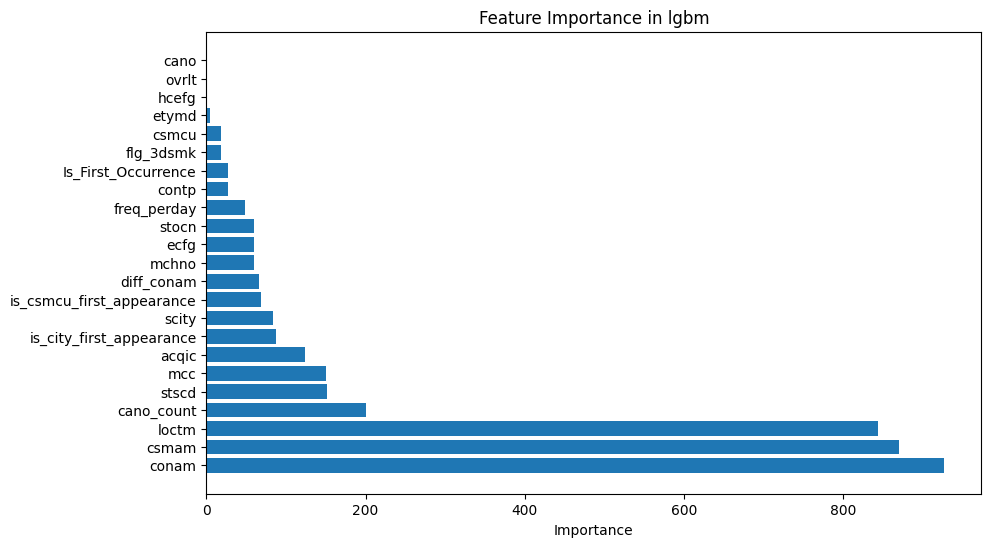

In [37]:
# Light GBM 
feature_importance_in_lgbm = bst.feature_importance(importance_type = 'split')  # 或 'gain'，取決於你想要的類型

# 獲取特徵名稱
feature_names_in_lgbm = bst.feature_name()

# 將特徵重要性轉換為 DataFrame
feature_importance_df_lgbm = pd.DataFrame({'Feature': feature_names_in_lgbm, 
                                           'Importance': feature_importance_in_lgbm}
                                           )

# 依照特徵重要性降序排序
feature_importance_df_lgbm = feature_importance_df_lgbm.sort_values(by = 'Importance', ascending = False)

# 繪製特徵重要性圖表
plt.figure(figsize = (10, 6))
plt.barh(feature_importance_df_lgbm['Feature'], 
         feature_importance_df_lgbm['Importance']
         )

plt.xlabel('Importance')
plt.title('Feature Importance in lgbm')
plt.show()

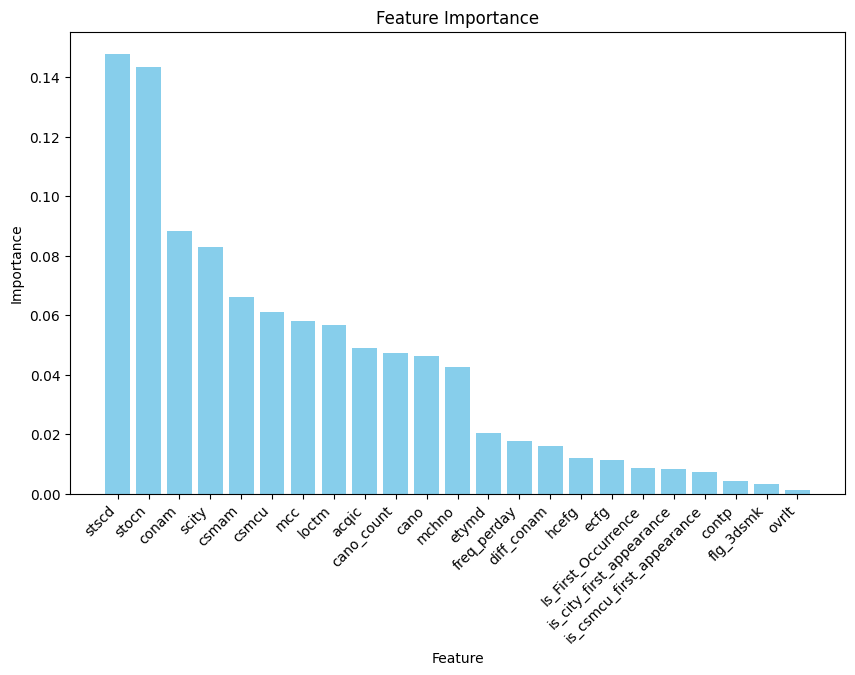

In [49]:
# Random forest 
feature_importance_in_rf = rf_classifier.feature_importances_

feature_importance_df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_in_rf
})

# 將 DataFrame 按照重要性排序
feature_importance_df_rf = feature_importance_df_rf.sort_values(by = 'Importance', ascending = False)

# 繪製條形圖
plt.figure(figsize = (10, 6))
plt.bar(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color = 'skyblue')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')  # 如果特徵名稱較多，可以旋轉 x 軸標籤
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

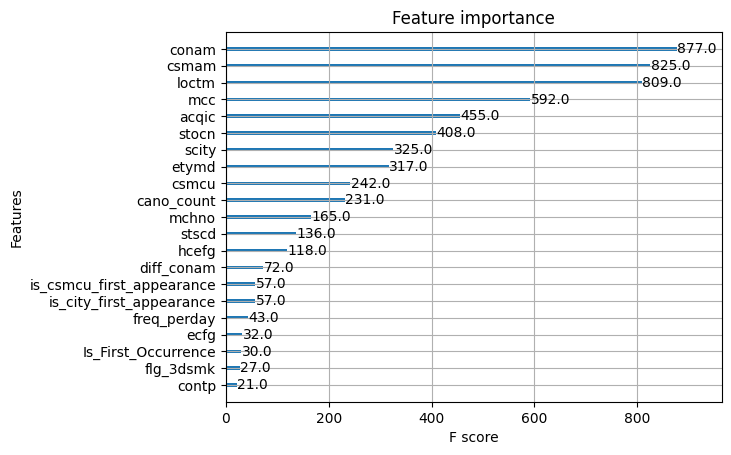

In [39]:
# XG boost
plot_importance(xgb_model)

#### Prediction Probability

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassi

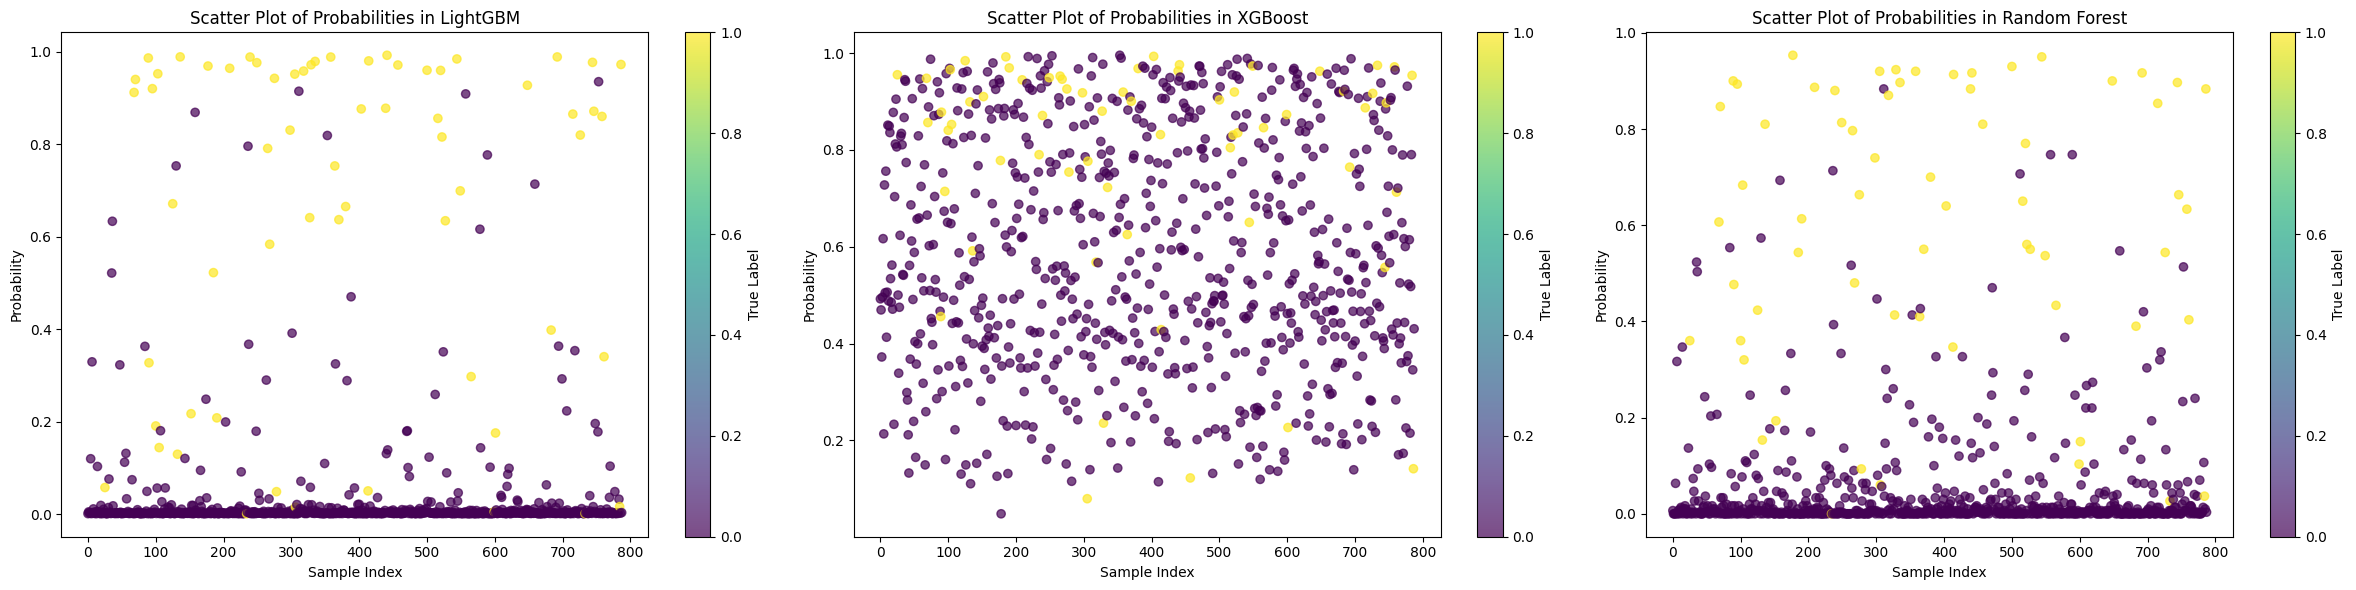

c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JUN-MING-WU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\J

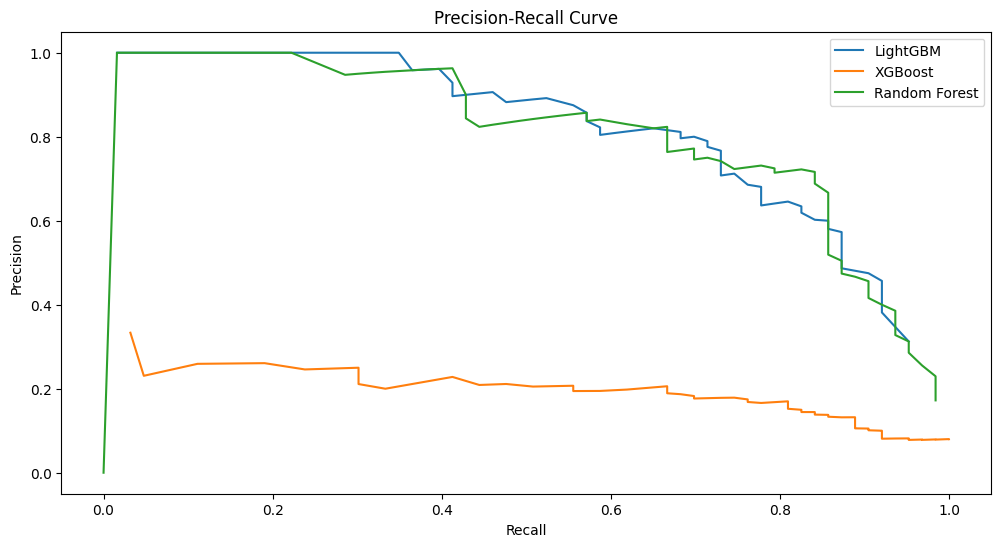

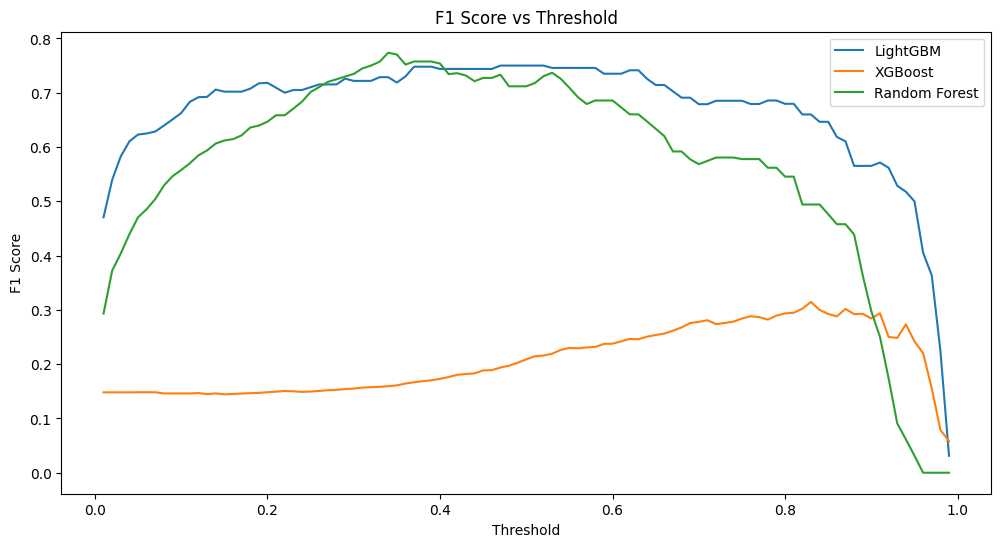

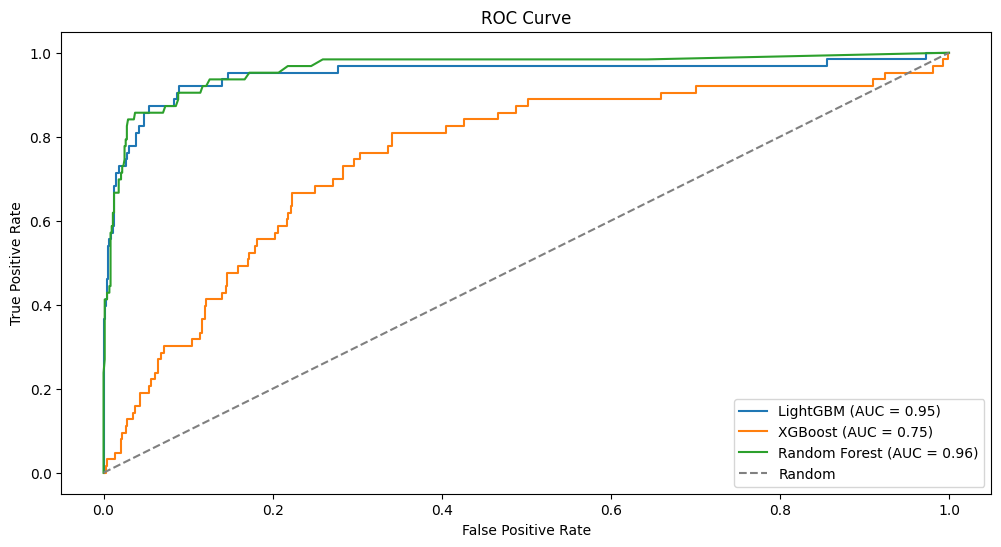

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

# 模型預測
y_probabilities_lgbm = bst.predict(X_test, num_iteration=bst.best_iteration)
y_probabilities_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_probabilities_rf = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in rf_classifier.estimators_], axis=0)

# 創建一個包含三個子圖的圖形
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# LightGBM 散點圖
scatter1 = ax1.scatter(range(len(y_test)), y_probabilities_lgbm, c=y_test.label, cmap='viridis', alpha=0.7)
ax1.set_title('Scatter Plot of Probabilities in LightGBM')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Probability')
fig.colorbar(scatter1, ax=ax1, label='True Label')

# XGBoost 散點圖
scatter2 = ax2.scatter(range(len(y_test)), y_probabilities_xgb, c=y_test.label, cmap='viridis', alpha=0.7)
ax2.set_title('Scatter Plot of Probabilities in XGBoost')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Probability')
fig.colorbar(scatter2, ax=ax2, label='True Label')

# Random Forest 散點圖
scatter3 = ax3.scatter(range(len(y_test)), y_probabilities_rf, c=y_test.label, cmap='viridis', alpha=0.7)
ax3.set_title('Scatter Plot of Probabilities in Random Forest')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Probability')
fig.colorbar(scatter3, ax=ax3, label='True Label')

plt.tight_layout()
plt.show()

# 計算不同閾值下的評估指標
thresholds = np.arange(0.01, 1, 0.01)

# 函數來計算評估指標
def calculate_metrics(y_true, y_prob, thresholds):
    predictions = [(y_prob >= threshold).astype(int) for threshold in thresholds]
    precision_values = [precision_score(y_true, prediction) for prediction in predictions]
    recall_values = [recall_score(y_true, prediction) for prediction in predictions]
    f1_values = [f1_score(y_true, prediction) for prediction in predictions]
    return precision_values, recall_values, f1_values

# 計算各模型的評估指標
precision_lgbm, recall_lgbm, f1_lgbm = calculate_metrics(y_test.label, y_probabilities_lgbm, thresholds)
precision_xgb, recall_xgb, f1_xgb = calculate_metrics(y_test.label, y_probabilities_xgb, thresholds)
precision_rf, recall_rf, f1_rf = calculate_metrics(y_test.label, y_probabilities_rf, thresholds)

# 繪製 Precision-Recall 曲線
plt.figure(figsize=(12, 6))
plt.plot(recall_lgbm, precision_lgbm, label='LightGBM')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 繪製 F1 分數曲線
plt.figure(figsize=(12, 6))
plt.plot(thresholds, f1_lgbm, label='LightGBM')
plt.plot(thresholds, f1_xgb, label='XGBoost')
plt.plot(thresholds, f1_rf, label='Random Forest')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 計算並繪製 ROC 曲線
plt.figure(figsize=(12, 6))
for y_prob, model_name in zip([y_probabilities_lgbm, y_probabilities_xgb, y_probabilities_rf],
                              ['LightGBM', 'XGBoost', 'Random Forest']):
    fpr, tpr, _ = roc_curve(y_test.label, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Max f1-score

In [48]:
# max f1-score
print(f"The max F1 score of Light GBM is {max(f1_values)}")
# print(f"The max F1 score of RF is {max(f1_values)}")
print(f"The max F1 score of XG Boost is {max(f1_values)}")

NameError: name 'f1_values' is not defined